15-8. 추가 Feature 추출
지금까지 RFM 분석을 위해서 가장 기본적인 RFM 스코어를 구했다면, 이번에는 그 외의 유저별 구매 패턴을 찾아보려고 합니다.

사실 RFM 분석 방법은 Recency, Frequency, Monetary에 의해 고객을 세그먼테이션하는 방법이지만 허점이 있습니다.

RFM 분석으로는 사이트에 방문한 횟수가 동일하고 비슷한 금액을 지출했지만 구매 패턴이 다른 사람을 분류하지 못합니다. 예를 들어 10개의 서로 다른 제품을 구매한 사람과 1개 상품을 10개 구매한 사람은 분명 다른 쇼핑 패턴을 가지고 있지만 RFM 분석으로는 같은 그룹으로 구분하겠죠.

또한 커머스에서 구매하는 제품의 폭이 넓은 사람일수록, 장기적으로 봤을 때 온라인 커머스 사이트에서 구매를 더 많이 할 가능성이 높아집니다. 디지털 제품만을 구매하는 사람이라면 새로 산 전자 기기가 고장날 때까지 재방문을 하지 않을 수도 있지만, 디지털 제품, 식품, 패션 상품을 고루 사던 사람이라면 다른 제품을 사러 재방문할 확률이 높으니까요.

그래서 이번에는 유저의 구매 패턴 속에서 뽑아낼 수 있는 추가적인 특징들이 있을지 살펴보려고 합니다. 크게 아래와 같이 3가지 측면에서 데이터를 분석할 것입니다.

구매하는 제품의 다양성
평균 구매 주기
구매 취소 경향성
다양한 속성 정보들을 모두 다 수집한 이후에 머신러닝을 활용하여 고객들을 자동으로 분류할 수 있는, 클러스터링 알고리즘을 활용해 볼 예정입니다. 아직 깊이 있게 머신러닝을 배우지 않았지만, SQL로 데이터를 분석하는 과정이 실제 현업에서 어떻게 '프로젝트'로 이어지는지 설명하기 위하여 간단한 머신러닝 기법을 활용한 클러스터링 및 분석 결과 시각화를 해볼 겁니다.

클러스터링 알고리즘이란?

클러스터링 알고리즘은 비슷한 특성을 가진 데이터 포인트들을 그룹화하는 기술을 말합니다. 데이터 속에 숨겨진 구조나 패턴을 찾아서 비슷한 데이터들끼리 그룹을 지어주는 것이죠.

클러스터링 알고리즘은 고객 세그먼테이션을 하는 것 외에도 굉장히 다양한 활용처들이 있습니다. 대표적인 클러스터링 활용 사례는 다음과 같습니다.

고객 세그먼테이션: 고객 데이터를 기반으로 비슷한 구매 패턴이나 선호도를 가진 고객 그룹을 찾아서 타겟 마케팅 전략을 최적화합니다.
이미지 분류: 비슷한 특징을 가진 이미지를 그룹화하여 이미지 검색 또는 분류를 개선합니다.
자연어 처리: 비슷한 주제를 가진 문서를 그룹화하여 정보 검색 및 텍스트 분석에 활용합니다.
의학 분야: 유사한 진단 패턴이나 환자 그룹을 식별하여 질병 진단을 지원합니다.
이상탐지: 정상 데이터 그룹과 다른 패턴을 가진 이상 데이터 그룹을 찾아 보안 및 이상 탐지에 사용합니다.



클러스터링 알고리즘에는 K-Means 클러스터링, 계층적 클러스터링, DBSCAN 등 다양한 종류가 있습니다. 선택한 알고리즘은 데이터의 특성과 목표에 따라 다를 수 있습니다.

이번 프로젝트에서는 K-Means 클러스터링을 활용해 보겠습니다.

클러스터링을 진행하기에 앞서, 유저별 구매 특성을 더 다양하게 뽑아보도록 하겠습니다.

1. 구매하는 제품의 다양성
이 단계에서는 고객들의 제품 구매 행동 속 구매 제품의 다양성을 살펴보려고 합니다. 고객이 얼마나 다양한 제품들에 관심 있는 사람인지를 알게 되면, 개인 맞춤형 마케팅 전략과 추천 서비스를 계획하는 데에도 큰 도움이 될 수 있습니다

우선 1) 고객 별로 구매한 상품들의 고유한 수를 계산합니다. 높은 숫자가 나오는 것은 해당 고객이 다양한 제품들을 구매한다는 의미이며, 낮은 값이 나오는 경우 소수의 제품들만 구매한다는 것을 의미합니다.

이후 2) user_rfm 테이블과 결과를 합치고, 이를 3) user_data라는 이름의 테이블에 저장하겠습니다.

In [ ]:
CREATE OR REPLACE TABLE marine-bay-411001.modulabs_project.user_data AS  
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM marine-bay-411001.modulabs_project.data2
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM marine-bay-411001.modulabs_project.user_rfm AS ur
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;

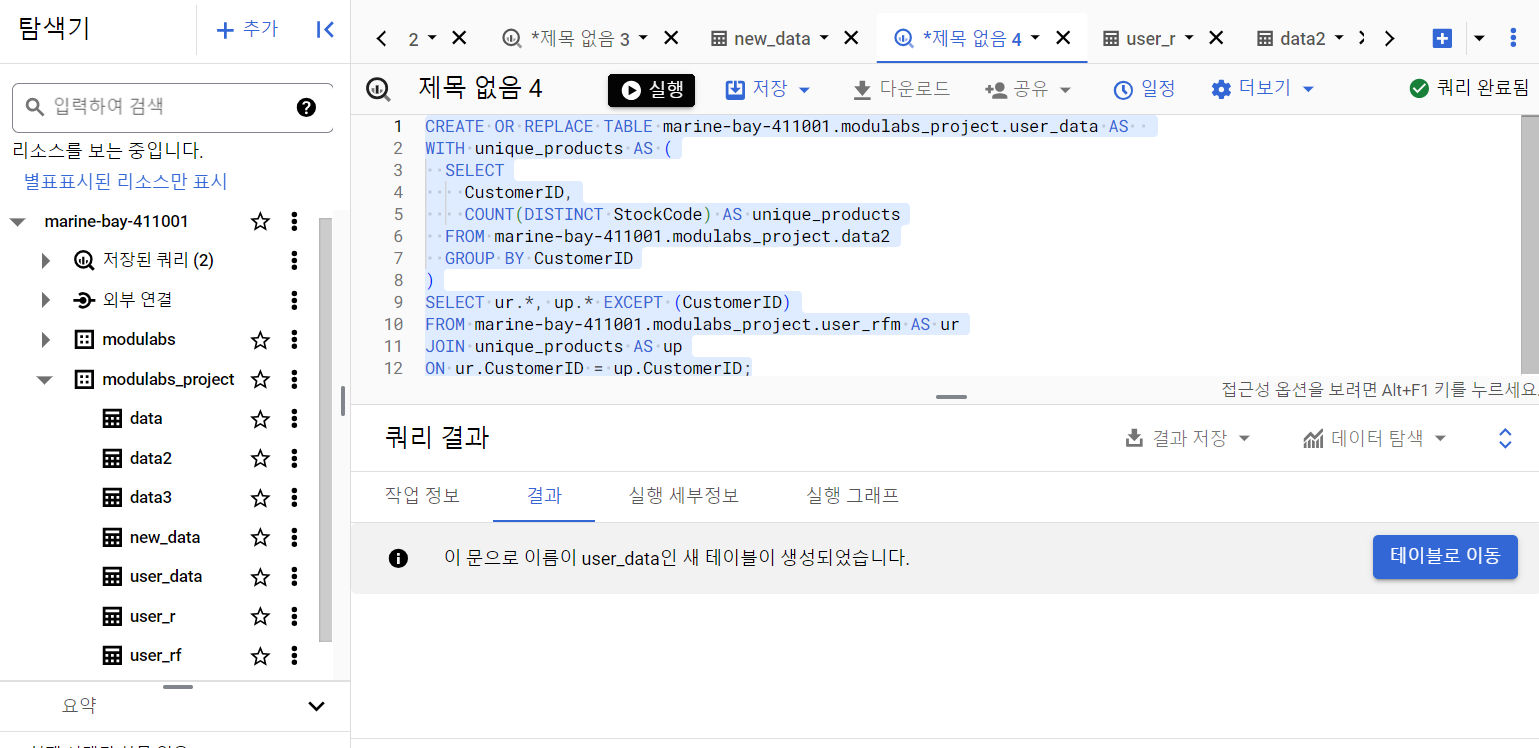

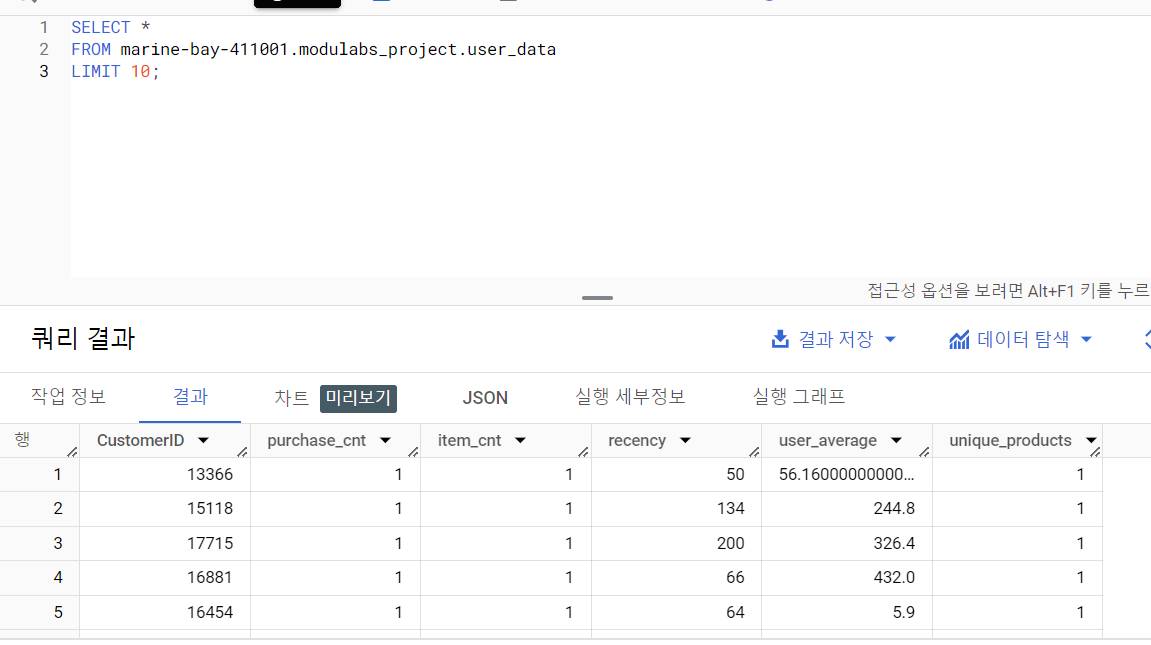

2. 평균 구매 주기
이 단계에서는 고객들의 쇼핑 패턴을 이해하는 것을 목표로 합니다. 그 중에서도 고객 별 재방문 주기를 살펴볼 것입니다. 고객들의 구매와 구매 사이의 기간이 평균적으로 몇 일인지를 보여주는 평균 일수를 계산하면, 고객이 다음 구매를 언제할지 예측하는 데에도 큰 도움이 됩니다. 평균 구매 소요 일수를 계산하고, 그 결과를 user_data에 통합해 줍시다.

In [ ]:
평균 구매 소요 일수를 계산하고, 그 결과를 user_data에 통합해 줍시다. 

CREATE OR REPLACE TABLE marine-bay-411001.modulabs_project.user_data AS 
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      marine-bay-411001.modulabs_project.user_data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM marine-bay-411001.modulabs_project.user_data AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;

In [ ]:
CREATE OR REPLACE TABLE marine-bay-411001.modulabs_project.user_data AS 
WITH purchase_intervals AS (
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      marine-bay-411001.modulabs_project.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT
  u.*,
  pi.average_interval
FROM
  marine-bay-411001.modulabs_project.data AS u
LEFT JOIN
  purchase_intervals AS pi
ON
  u.CustomerID = pi.CustomerID;

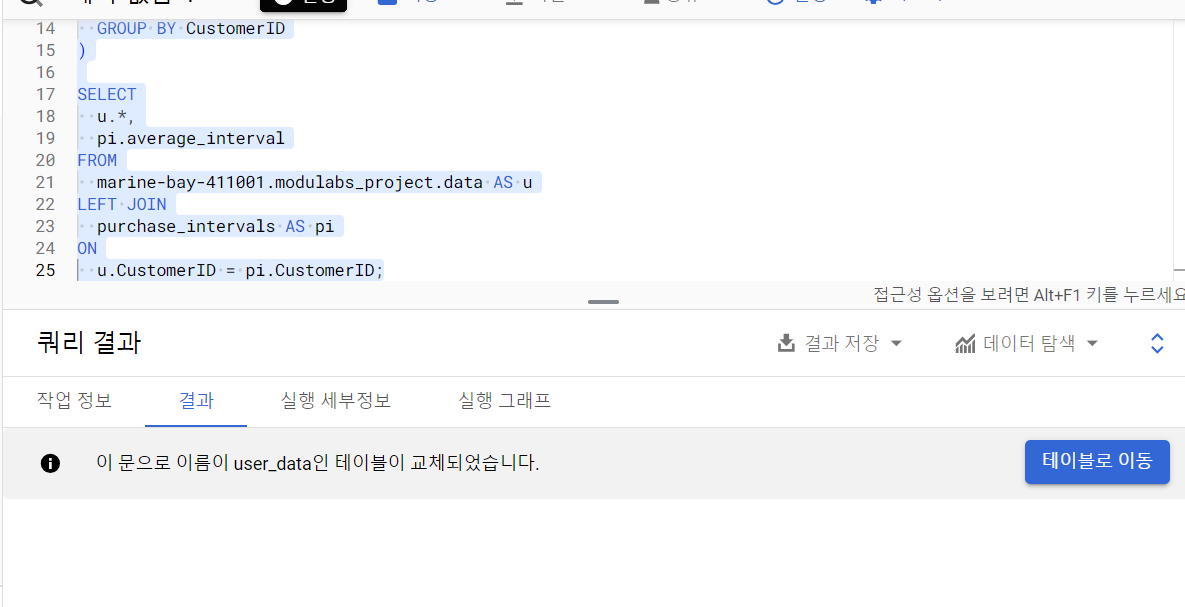

In [1]:
import pandas as pd

# CSV 파일 경로
file_path = (r'C:\Users\pig30n77\Downloads\bquxjob_7e4508a8_18d0c52944d.csv')

# CSV 파일 읽기
data = pd.read_csv(file_path)

# 데이터 확인
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,average_interval
0,574301,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2011-11-03 16:15:00.000000 UTC,2.95,12544,Spain,0.32
1,574301,22751,FELTCRAFT PRINCESS OLIVIA DOLL,4,2011-11-03 16:15:00.000000 UTC,3.75,12544,Spain,0.32
2,574301,23514,EMBROIDERED RIBBON REEL SALLY,6,2011-11-03 16:15:00.000000 UTC,2.08,12544,Spain,0.32


In [ ]:
회고 : 시간 부족으로 여기까지 밖에 못해서 아쉽습니다.
    하면 할 수록 재밌었습니다. :) 